# Feature selection (RDKit descriptors):
**Selecting molecular descriptors following the Ash & Fourches (2017) procedure** (it is assumed that these steps were made independently for each set of descriptors):
1. **Low variance filter:** Features in the lower variance quartile were discarde.
    - This means that at least 25% of the features will be removed.
    
    
2. **Correlation filters:** For any pair of descriptors with $|r| > 0.9$ the descriptor with largest mean of $|r|$ was removed.

#### Additionaly they did the following analysis (not necessarily to drop features):
1. **Pearson correlation between each descriptor and pKi values.**  
2. **Paired t-test between active and inactive ligands using each set of descriptors.**

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [2]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')

RDKit WARNING: [19:22:26] Enabling RDKit 2019.09.1 jupyter extensions


# MACC Keys

In [3]:
#  Let's extract the MACCS Keys as a Data frame
s = df_erk2_mols.maccs.map(lambda x: list(map(np.float, x)))
df_maccs_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
# We have to clarify that MACCS Keys from rdkit includes a dummy key at the begining due to the 0 indexing
# Let's drop it
df_maccs_all = df_maccs_all.drop([0], axis=1)
df_maccs_all.head()

,1,2,3,4,5,6,7,8,9,10,...,157,158,159,160,161,162,163,164,165,166
CSAR_erk2_18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CSAR_erk2_20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CSAR_erk2_17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CSAR_erk2_16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
CSAR_erk2_15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


### Variance Threshold

Ash and Fourches dropped all the features/bits inside the lower quartile of the feature variances. This meas they would remove 166/4 ~ 42 variables; however, they actually remove 45 variables (see Table 1). 

##### In our results, how many bits have only 0 or 1 values?

In [4]:
n_ones = (df_maccs_all.sum().values == 87).sum()
n_zeros = (df_maccs_all.sum().values == 0).sum()
print('Features/bits with only 1 values:', n_ones)
# How many bits have only zeros
print('Features/bits with only 0 values:', n_zeros)
# Number of constant features
print('# of constant features:', n_ones + n_zeros)

Features/bits with only 1 values: 9
Features/bits with only 0 values: 37
# of constant features: 46


 We can start by droping these 42 features with only zeros, then we'll have 129 remained bits

##### Use the VarianceThreshold class from *sklearn*:

In [5]:
from sklearn.feature_selection import VarianceThreshold

In [6]:
sel_var = VarianceThreshold(0)
df_maccs_flt1 = sel_var.fit_transform(df_maccs_all)
df_maccs_flt1.shape

(87, 120)

##### Boolean features (Bernoulli rvs)
Assuming each descriptor is a Bernoulli random variable with $p = n_a/N$:
> $var(x) = p(1 - p)$

In [7]:
n = 87
p = df_maccs_all.sum()/n
var = p*(1-p)
# As expected the result is the  same as the given by sklearn
q = np.percentile(var.values, 0.25)
df_maccs_flt_var = df_maccs_all.loc[:, var.values > q]
df_maccs_flt_var.shape

(87, 120)

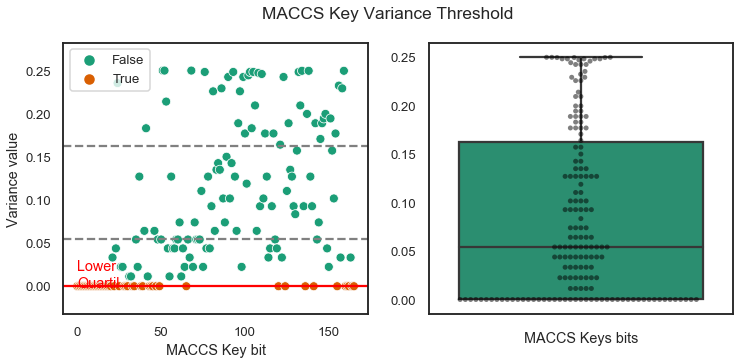

46 features were dropped.


In [10]:
# Plot variances
sns.set(style='white', palette='Dark2', context='talk', font_scale=0.8)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MACCS Key Variance Threshold')
q1, q2, q3 = np.quantile(var.values, [0.25, 0.5, 0.75])
ax1 = sns.scatterplot(x=range(0,166), y=var, ax=ax1, hue=(var <= q1))
ax1.set(xlabel='MACCS Key bit', ylabel='Variance value')
ax1.annotate('Lower\nQuartil', xy=(0, q1), color='red')
ax1.axhline(q1, color='red')
ax1.axhline(q2, color='grey', linestyle='--')
ax1.axhline(q3, color='grey', linestyle='--')
ax2 = sns.boxplot(y=var, ax=ax2)
ax2 = sns.swarmplot(y=var, ax=ax2, color='black', alpha=0.5)
ax2.set(xlabel='MACCS Keys bits')
plt.show()

print(sum(var <= q1), 'features were dropped.')

#### Visualizing the remained features

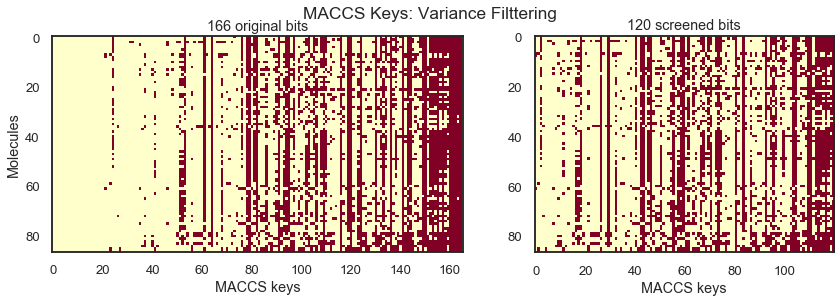

In [15]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1], width_ratios=[1.1, 0.8])
fig = plt.figure(figsize=(14, 4))
fig.suptitle('MACCS Keys: Variance Filttering')
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xlab = 'MACCS keys'
ax1.imshow(df_maccs_all, cmap='YlOrRd')
ax1.set(title='166 original bits', xlabel=xlab, ylabel='Molecules')
ax2.imshow(df_maccs_flt_var, cmap='YlOrRd')
ax2.set(title='120 screened bits', xlabel=xlab)
plt.show()

### Correlation Filtering 

#### Matthews correlation coefficient (phi corr. coef.)

In [16]:
from sklearn.metrics import matthews_corrcoef

0.03571428571428571


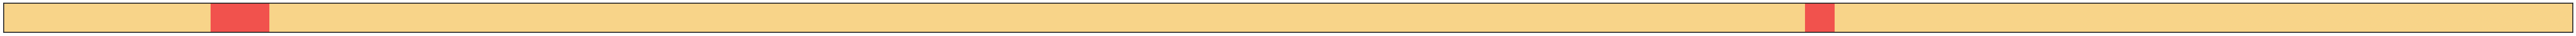

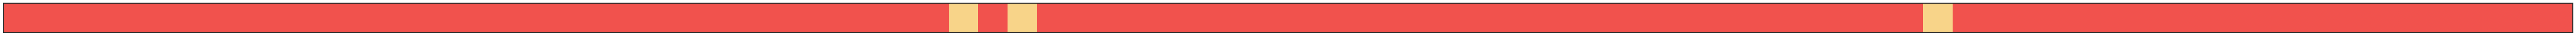

In [23]:
print(matthews_corrcoef(df_maccs_flt_var[ 22 ],
                  df_maccs_flt_var[ 164 ]))

bit_92_palette = ['#f1524d' if i else '#f8d489' for i in df_maccs_flt_var[22].values]
sns.palplot(sns.color_palette(bit_92_palette))

bit_110_palette = ['#f1524d' if i else '#f8d489' for i in df_maccs_flt_var[164].values]
sns.palplot(sns.color_palette(bit_110_palette))

In [42]:
n_features = len(df_maccs_flt_var.columns)
# Create the empty matrix
phi_corr_mtx = np.zeros((n_features, n_features))

for idx_i, f_i in enumerate(df_maccs_flt_var.columns):
    for idx_j, f_j in enumerate(df_maccs_flt_var.columns):
        # Compute Matthew's correlation coef
        phi = matthews_corrcoef(df_maccs_flt_var[ f_i ],
                          df_maccs_flt_var[ f_j ])
        # Add to the matrix
        phi_corr_mtx[idx_i, idx_j] = phi
    

In [56]:
phi_corr_mtx

array([[ 1.        ,  0.25929369, -0.01790718, ..., -0.12246441,
        -0.1956152 ,  0.03571429],
       [ 0.25929369,  1.        , -0.17161334, ...,  0.16333445,
        -0.22723361,  0.04148699],
       [-0.01790718, -0.17161334,  1.        , ...,  0.13645283,
         0.6130103 ,  0.14773421],
       ...,
       [-0.12246441,  0.16333445,  0.13645283, ...,  1.        ,
         0.19377661,  0.25400025],
       [-0.1956152 , -0.22723361,  0.6130103 , ...,  0.19377661,
         1.        ,  0.1956152 ],
       [ 0.03571429,  0.04148699,  0.14773421, ...,  0.25400025,
         0.1956152 ,  1.        ]])

#### Fourches feature selection using correlations

In [ ]:
def filter_corr_fourches(df, threshold=0.9, absolute=True):
    

In [124]:
feat_names = df_maccs_flt_var.columns
threshold=0.9
x = phi_corr_mtx
np.fill_diagonal(x, 1.1)
# Sum all corr values per each feature

df_x_ = pd.DataFrame(x, columns=feat_names, index=feat_names)
df_x = abs(df_x_)
sum_coefs = df_x.sum(axis=0)

c = df_x[(df_x >= threshold) & (df_x < 1.1)]
g = c.dropna(how='all', axis=1).dropna(how='all', axis=0)

feats_to_drop = set()
# Iterate over the columns
for col, values in g.iteritems():

    corr_columns = g[col].dropna().index.tolist()
    # append the current feature
    corr_columns.append(col)
    
    # Get the feature with higher sum_coefs
    feats_to_drop.add(sum_coefs[corr_columns].idxmax())
    
len(feats_to_drop)

27

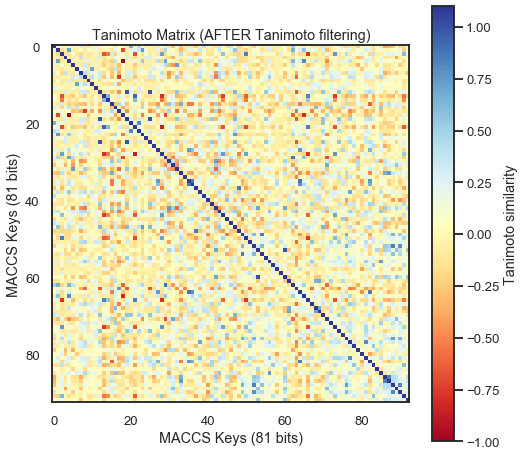

In [126]:
fig = plt.figure(figsize=(8,8))
plt.imshow(df_x_.drop(feats_to_drop, axis=1).drop(feats_to_drop, axis=0), cmap='RdYlBu')

plt.xlabel('MACCS Keys (81 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Tanimoto Matrix (AFTER Tanimoto filtering)')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

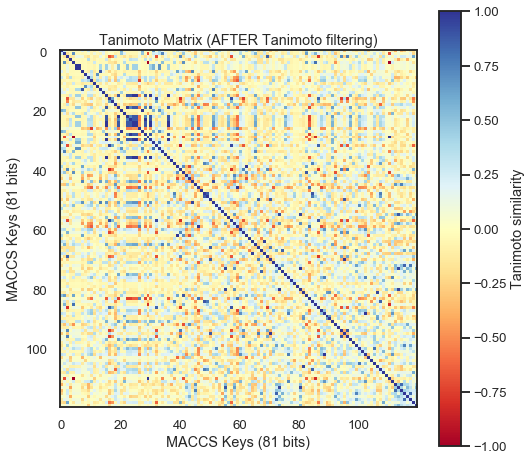

In [57]:
fig = plt.figure(figsize=(8,8))
plt.imshow(phi_corr_mtx, cmap='RdYlBu')

plt.xlabel('MACCS Keys (81 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Tanimoto Matrix (AFTER Tanimoto filtering)')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

#### Tanimoto similarity

In [ ]:
from scipy.spatial.distance import pdist, squareform
from correlation_filter import *

In [ ]:
# Better than correlation, we should use a similarity metric to compare the binary vectors
# From this perspective we're not comparing similarity between observations, but between features
# We substract the value (distance) from 1 to get similarity
cm_jaccard = pdist(df_maccs_flt_var.T, 'jaccard') 
# Convert to a matrix and plot it
mtx_tan = 1 - squareform(cm_jaccard)
# Let's force the diagonal to have values above 1 to distinguish between these values
np.fill_diagonal(mtx_tan, 1.1)
# convert to  a DataFrame
df_tan = pd.DataFrame(mtx_tan, index=df_maccs_flt_var.columns, columns=df_maccs_flt_var.columns)

As an example let's visualize features with similar behavior inside the dataset

Features 51 and 60 have a Tanimoto coef. of: 1.0


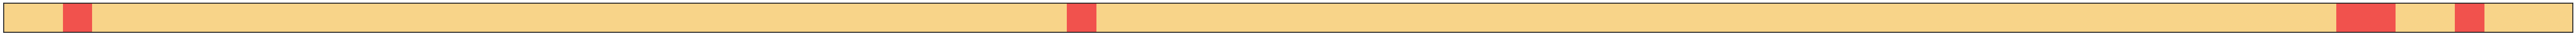

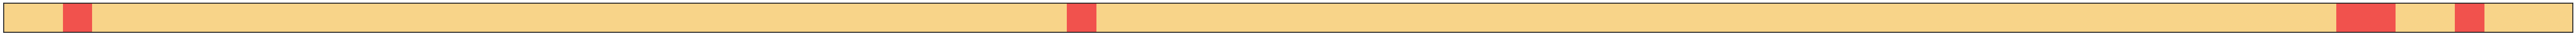

In [11]:
tan_max_idx1_ie = df_tan[df_tan < 1.1].max().idxmax()
tan_max_idx2_ie = df_tan[df_tan < 1.1].loc[: , tan_max_idx1_ie].idxmax()
tan_coef_value_example = df_tan.loc[tan_max_idx1_ie, tan_max_idx2_ie]

# Example
print('Features', tan_max_idx1_ie, 'and', tan_max_idx2_ie, 'have a Tanimoto coef. of:', tan_coef_value_example)
# Plot them
bit_92_palette = ['#f1524d' if i else '#f8d489' for i in df_maccs_flt_var.loc[:, tan_max_idx1_ie].values]
sns.palplot(sns.color_palette(bit_92_palette))

bit_110_palette = ['#f1524d' if i else '#f8d489' for i in df_maccs_flt_var.loc[:, tan_max_idx2_ie].values]
sns.palplot(sns.color_palette(bit_110_palette))

#### Dropping features (bits)
Adapting the strategy used by Fourches;
1. We're  going to sum all Tanimoto  coefficients per each feature.
2. We'll identify all feature pairs with Tanimoto coefficient higher than 0.95

In [23]:
bits_to_drop = features_to_drop(df_tan, max_thr = 1, min_thr = 0.99, step =  0.01, verbose = False)
# Drop the features:
df_maccs_flt_corr = df_maccs_flt_var.drop(bits_to_drop, axis=1)
# Get the new tanimoto matrix just to plot and compare
_cm_jaccard = pdist(df_maccs_flt_corr.T, 'jaccard') 
_mtx_tan = 1 - squareform(_cm_jaccard)
np.fill_diagonal(_mtx_tan, 1.1)
_df_tan = pd.DataFrame(_mtx_tan, index=df_maccs_flt_corr.columns, columns=df_maccs_flt_corr.columns)

In [39]:
df_maccs_flt_corr.shape

(87, 81)

#### Visualization before and after feature selection

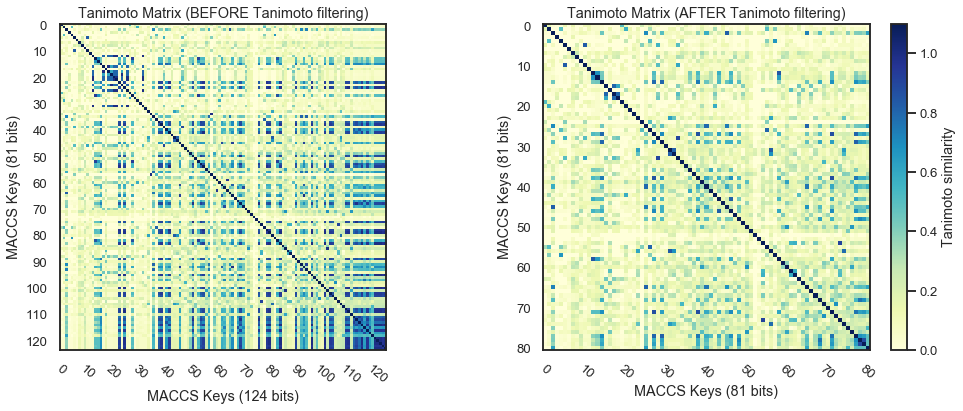

In [43]:
fig = plt.figure(figsize=(17, 6))

plt.subplot(1, 2, 1)
plt.imshow(df_tan, cmap='YlGnBu')
plt.yticks(range(0, 125, 10))
plt.xticks(range(0, 125, 10), rotation=-40)
plt.xlabel('MACCS Keys (124 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Tanimoto Matrix (BEFORE Tanimoto filtering)')

plt.subplot(1, 2, 2)
plt.imshow(_df_tan, cmap='YlGnBu')
plt.yticks(range(0, 81, 10))
plt.xticks(range(0, 81, 10), rotation=-40)
plt.xlabel('MACCS Keys (81 bits)'); plt.ylabel('MACCS Keys (81 bits)')
plt.title('Tanimoto Matrix (AFTER Tanimoto filtering)')

cbar = plt.colorbar()
cbar.set_label('Tanimoto similarity')
plt.show()

#### Recursive Feature Elimination and Logistic Regression to drop features

In [49]:
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

In [53]:
# Define the sets
y = df_erk2_mols.activity
X = df_maccs_all

In [55]:
# We'll use a Logistic Regression Clasifier to perform Feature Selection
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
ref_lg = RFE(estimator = lg, n_features_to_select = 97, step = 1)
ref_lg.fit(X, y)

RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                 fit_intercept=True, intercept_scaling=1,
                                 l1_ratio=None, max_iter=100,
                                 multi_class='auto', n_jobs=None, penalty='l2',
                                 random_state=None, solver='lbfgs', tol=0.0001,
                                 verbose=0, warm_start=False),
    n_features_to_select=97, step=1, verbose=0)

In [56]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
ref_tree = RFE(estimator = tree, n_features_to_select = 97, step = 1)
ref_tree.fit(X, y)

RFE(estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features=None, max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     presort='deprecated', random_state=None,
                                     splitter='best'),
    n_features_to_select=97, step=1, verbose=0)

## RDKit 2D Descriptors

In [ ]:
### KNIME

In [ ]:
rdk2d_knime = pd.read_csv('knime/2d_rdki_knime.csv')
rdk2d_knime['Filename'] = rdk2d_knime['Filename'].apply(lambda x: x.split('.')[0])
rdk2d_knime = rdk2d_knime.set_index('Filename')
rdk2d_knime = rdk2d_knime.iloc[:, 6:]

rdk2d_knime = rdk2d_knime.reindex(df_rdkit_all.index)

In [ ]:
### RDKit

In [ ]:
from rdkit.Chem import Descriptors
# MQN Descriptors go from 1 to 42
names_MQN = ['MQN' + str(i) for i in range(1, 43)]

# Final Lsit of descirptors
names_of_all_rdkit_descriptors = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
FINAL_names_of_all_rdkit_descriptors = names_of_all_rdkit_descriptors + ['CalcNumAtomStereoCenters',
                                                                        'CalcNumUnspecifiedAtomStereoCenters',
                                                                        'GetNumAtoms'] + names_MQN

In [ ]:
s = df_erk2_mols['2d_rdkit'].map(lambda x: x)
df_rdkit_all = pd.DataFrame.from_dict(dict(zip(s.index, s.values))).T
df_rdkit_all.columns = FINAL_names_of_all_rdkit_descriptors
df_rdkit_all

In [ ]:
df_rdkit_all.columns

In [ ]:
rdk2d_knime.columns